# Overview
*Problem statement (what question am I trying to answer?), why this type of work might be useful, how I approached this project, and my findings.*

### Objective

**Purpose:** Predict users' (MBTI) personality types based on 50 raw text posts provided from Kaggle data set. 

**Use cases:** Predicting personality features based on written data could be used to better underestand clients, consumers, marketing audiences, or employees. For example, orgnizations could improve collaboration between employees or between employees & bosses by accomodating their personality types ("E"s might like to brainstrorm aloud, "T"s tend to be more logic-oriented in their thinking.) Marketing platforms take these features into account to create audiences.

**Data Source:** https://www.kaggle.com/datasnaek/mbti-type

### Approach

There are a few ways to predict personality type based on this data:
    - Randomly guess (~6% accuracy)
    - Always guess most common personality type (~21% accuracy)
    - Build a model! (TBD...)

### Model performance

 - **Logistic Regression w/ NLP** generated highest predictive accuracy at <font color=green>**65%**</font>
     - Simpler versions of logistic regression also outperformed uninformed guessing, with inclusion of text data driving the bigest increase in accuracy
 - KNN and Random Forest approaches saw small improvement over uninformed guessing, which is probably due to the fact that they were not informed by raw text data behind derived featured columns

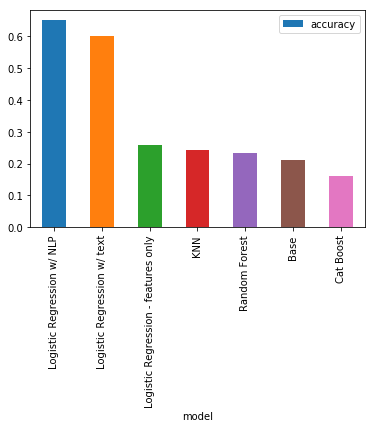

In [1667]:
compare_models.sort_values(by=['accuracy'], ascending = False).plot(kind='bar', x='model', y='accuracy')


### Next Steps

"Success" in this sense was 100% correct personality guesses. However, I would assume that a 3/4 match might also be useful for the applications mentioned above. Personality characteristics are also assigned on a spectrum, which none of these models accounts for.


# Technical Details

### Step 1: Import Packages & dataset

In [1544]:
import re
import string
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [1545]:
# import csv data set

mbti = pd.read_csv('/Users/emoneil93/Desktop/General_Assembly/kaggle_datasets/MBTI.csv', sep=',')


### Step 2: Explore & Prepare DataSet
*Filter and manipulate existing data, add new feature columns based on provided posts.*

#### View preliminary dataset:

In [1546]:
mbti.head()

,type,posts
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw|htt...
1,ENTP,I'm finding the lack of me in these posts very...
2,INTP,Good one _____ https://www.youtube.com/watc...
3,INTJ,"Dear INTP, I enjoyed our conversation the ot..."
4,ENTJ,You're fired.|That's another silly misconcepti...


#### Show unique combinations of personality types

In [1547]:
pd.Series(mbti.type.unique())

0     INFJ
1     ENTP
2     INTP
3     INTJ
4     ENTJ
5     ENFJ
6     INFP
7     ENFP
8     ISFP
9     ISTP
10    ISFJ
11    ISTJ
12    ESTP
13    ESFP
14    ESTJ
15    ESFJ
dtype: object

#### Look at breakdown of data by personality type

,posts,share
type,,
INFP,1832,21%
INFJ,1470,16%
INTP,1304,15%
INTJ,1091,12%
ENTP,685,7%
ENFP,675,7%
ISTP,337,3%
ISFP,271,3%
ENTJ,231,2%


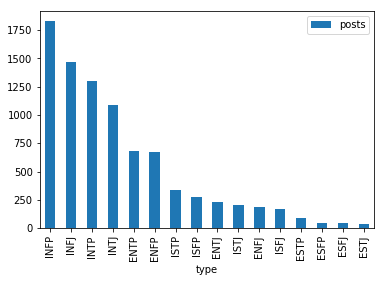

In [1548]:
# construct data frame containing total post count and % total for each distinct personality type

total_count = mbti.type.count()
personality_shares = pd.DataFrame(mbti[['type', 'posts']].groupby('type').count())
personality_shares['share'] = (personality_shares.posts / total_count)
personality_shares['share'] = [str(int(x*100)) + '%' for x in personality_shares.share]

mbti[['type', 'posts']].groupby('type').count().sort_values(by=['posts'], ascending = False).plot(kind='bar')

personality_shares.sort_values(by=['posts'], ascending = False)


#### Check for nulls:

In [1549]:
# check for nulls 

mbti.isnull().sum()


type     0
posts    0
dtype: int64

#### Reformat raw post text for easier analysis

In [1550]:
# convert to lowercase

mbti['posts'] = mbti['posts'].str.lower()

# add space after domain names in URLs for easier recognition

mbti['posts'] = mbti.posts.replace({'.com/': '.com/ '}, regex=True)

# create column in textblock format

mbti['textblob_posts'] = [TextBlob(x) for x in mbti.posts]

print('Textblob format: ' + str(type(mbti.textblob_posts[0])))


Textblob format: <class 'textblob.blob.TextBlob'>


#### Create functions that will help create new features from raw post text

In [1551]:
def english(string):
    non_english = []
    string = string.lower()
    for char in string:
        if char.isalnum() == True and char not in 'aäbcdeéfghijklmnopqrstuvwxyz1234567890':
            non_english.append(char)
        else:
            pass
    non_english = ''.join(non_english)
    return non_english

def english_binary(string):
    if english(string) == '':
        return 1
    else:
        return 0

def assign_e(string):
    if string[0] == 'E':
        return 1
    else:
        return 0

def assign_n(string):
    if string[1] == 'N':
        return 1
    else:
        return 0
    
def assign_t(string):
    if string[2] == 'T':
        return 1
    else:
        return 0

def assign_j(string):
    if string[3] == 'J':
        return 1
    else:
        return 0

#### Generate new feature columns using above functions

In [1552]:
# evaluate non-english characters

mbti['special_characters'] = [english(x) for x in mbti.posts]
mbti['english'] = [english_binary(x) for x in mbti.posts]

# assign binary values for each of the 4 MBTI characteristics

mbti['e'] = [assign_e(x) for x in mbti.type]
mbti['n'] = [assign_n(x) for x in mbti.type]
mbti['t'] = [assign_t(x) for x in mbti.type]
mbti['j'] = [assign_j(x) for x in mbti.type]


In [1553]:
# look at examles of special characters

mbti[mbti['english'] == 0].special_characters.head(10)

21               ïïè
52                 ø
83                ââ
88                σд
146              유재석
154     żłååöððáóáóà
167    µ好了中文是太易我是英国人
184           ˌɪəˈɪɪ
185                â
214               ˈə
Name: special_characters, dtype: object

#### Generate quantitative columns containing info from raw text

In [1554]:
# generate other quantitative data extracted from posts

mbti['total_length'] = mbti.posts.apply(len)


In [1555]:
mbti.head()

,type,posts,textblob_posts,special_characters,english,e,n,t,j,total_length
0,INFJ,http://www.youtube.com/ watch?v=qsxhcwe3krw|ht...,"(h, t, t, p, :, /, /, w, w, w, ., y, o, u, t, ...",,1,0,1,0,1,4577
1,ENTP,i'm finding the lack of me in these posts very...,"(i, ', m, , f, i, n, d, i, n, g, , t, h, e, ...",,1,1,1,1,0,6963
2,INTP,good one _____ https://www.youtube.com/ wat...,"(g, o, o, d, , o, n, e, , , _, _, _, _, _, ...",,1,0,1,1,0,5171
3,INTJ,"dear intp, i enjoyed our conversation the ot...","(d, e, a, r, , i, n, t, p, ,, , , , i, , ...",,1,0,1,1,1,6174
4,ENTJ,you're fired.|that's another silly misconcepti...,"(y, o, u, ', r, e, , f, i, r, e, d, ., |, t, ...",,1,1,1,1,1,6016


#### Create new feature columns based on elements that appear in text

In [1556]:
# create new feature columns

mbti['links_count'] = [x.count('.com') for x in mbti.posts]
mbti['youtube_count'] = [x.count('youtube.com') for x in mbti.posts]
mbti['reddit_count'] = [x.count('reddit.com') for x in mbti.posts]
mbti['img_count'] = [x.count('jpg') + x.count('jpeg') for x in mbti.posts]
mbti['exclamation_count'] = [x.count('!') for x in mbti.posts]
mbti['triple_exclamation_count'] = [x.count('!!!') for x in mbti.posts]
mbti['ellipses_count'] = [x.count('...') for x in mbti.posts]
mbti['question_count'] = [x.count('?') for x in mbti.posts]
mbti['me_count'] = [x.count(' i ') + x.count(' me ') for x in mbti.posts]
mbti['you_count'] = [x.count(' you ') + x.count(' your ') for x in mbti.posts]
mbti['we_count'] = [x.count(' we ') + x.count(' us ') + x.count(' our ') for x in mbti.posts]
mbti['like_count'] = [x.count(' like ') + x.count(' our ') for x in mbti.posts]
mbti['love_count'] = [x.count(' love ') + x.count(' our ') for x in mbti.posts]
mbti['lol_count'] = [x.count(' lol ') + x.count(' our ') for x in mbti.posts]


#### Perform sentiment analysis on posts

In [1557]:
# perform sentiment analysis on posts in textblob format

mbti['sentiment'] = [int(round(x.sentiment.polarity*100, 0)) for x in mbti.textblob_posts]


#### Look at differences in feature columns by personality type

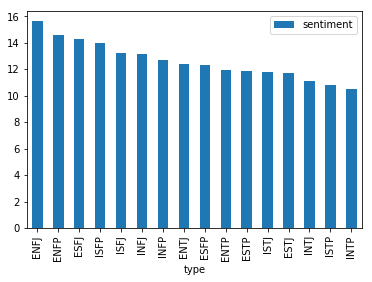

In [1668]:
mbti[['type', 'sentiment']].groupby('type').mean().sort_values(by=['sentiment'], ascending = False).plot(kind='bar')

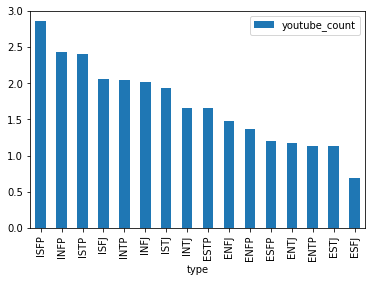

In [1669]:
mbti[['type', 'youtube_count']].groupby('type').mean().sort_values(by=['youtube_count'], ascending = False).plot(kind='bar')

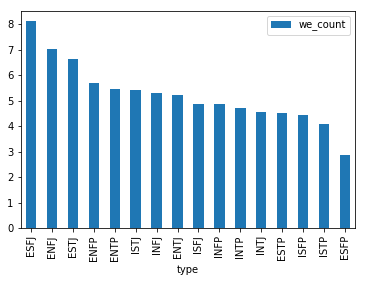

In [1670]:
mbti[['type', 'we_count']].groupby('type').mean().sort_values(by=['we_count'], ascending = False).plot(kind='bar')


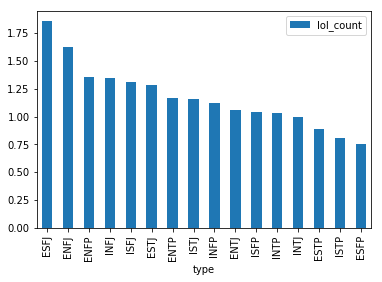

In [1674]:
mbti[['type', 'lol_count']].groupby('type').mean().sort_values(by=['lol_count'], ascending = False).plot(kind='bar')


#### Create dummy variables for personality type <font color=red><<didn't end up using this</font>


In [1558]:
# generate dummy variables from type category

mbti_dummies = pd.get_dummies(mbti.type, prefix='type')
mbti_dummies.drop(mbti_dummies.columns[0], axis=1, inplace=True)

# concat dummy variables

mbti_dummy = pd.concat([mbti, mbti_dummies], axis = 1)


In [1559]:
personality_shares.sort_values(by=['posts'], ascending = False)

,posts,share
type,,
INFP,1832,21%
INFJ,1470,16%
INTP,1304,15%
INTJ,1091,12%
ENTP,685,7%
ENFP,675,7%
ISTP,337,3%
ISFP,271,3%
ENTJ,231,2%


In [1560]:
# map each personality type to a number

mbti['type_num'] = mbti.type.map({
                                'INFP':0, 'INFJ':1, 'INTP':2, 'INTJ': 3,
                                'ENTP':4, 'ENFP':5, 'ISTP':6, 'ISFP': 7,
                                'ENTJ':8, 'ISTJ':9, 'ENFJ':10, 'ISFJ': 11,
                                'ESTP':12, 'ESFP':13, 'ESFJ':14, 'ESTJ': 15
                                }, )

#### Review final table

In [1561]:
# check for nulls 

mbti.isnull().sum()

type                        0
posts                       0
textblob_posts              0
special_characters          0
english                     0
e                           0
n                           0
t                           0
j                           0
total_length                0
links_count                 0
youtube_count               0
reddit_count                0
img_count                   0
exclamation_count           0
triple_exclamation_count    0
ellipses_count              0
question_count              0
me_count                    0
you_count                   0
we_count                    0
like_count                  0
love_count                  0
lol_count                   0
sentiment                   0
type_num                    0
dtype: int64

In [1562]:
# view final dataset

mbti.head()

,type,posts,textblob_posts,special_characters,english,e,n,t,j,total_length,...,ellipses_count,question_count,me_count,you_count,we_count,like_count,love_count,lol_count,sentiment,type_num
0,INFJ,http://www.youtube.com/ watch?v=qsxhcwe3krw|ht...,"(h, t, t, p, :, /, /, w, w, w, ., y, o, u, t, ...",,1,0,1,0,1,4577,...,15,18,10,12,0,3,0,0,15,1
1,ENTP,i'm finding the lack of me in these posts very...,"(i, ', m, , f, i, n, d, i, n, g, , t, h, e, ...",,1,1,1,1,0,6963,...,19,5,67,24,5,15,2,1,12,4
2,INTP,good one _____ https://www.youtube.com/ wat...,"(g, o, o, d, , o, n, e, , , _, _, _, _, _, ...",,1,0,1,1,0,5171,...,13,12,19,19,2,2,1,0,17,2
3,INTJ,"dear intp, i enjoyed our conversation the ot...","(d, e, a, r, , i, n, t, p, ,, , , , i, , ...",,1,0,1,1,1,6174,...,26,11,45,22,12,8,5,5,11,3
4,ENTJ,you're fired.|that's another silly misconcepti...,"(y, o, u, ', r, e, , f, i, r, e, d, ., |, t, ...",,1,1,1,1,1,6016,...,21,10,24,15,5,7,2,2,6,8


## Step 3: Run & Evaluate Different Models

### Split Data

In [1653]:

X_all = mbti.drop(['type', 'reddit_count', 'total_length', 'english','type_num', 'textblob_posts', 'special_characters', 'e', 'n', 't', 'j'], axis=1)
X = mbti.drop(['type', 'reddit_count', 'total_length', 'english','type_num', 'textblob_posts', 'posts', 'special_characters', 'e', 'n', 't', 'j'], axis=1)
y = mbti['type_num']

X_train, X_test, y_train, y_test, X_all_train, X_all_test = train_test_split(X, y, X_all, test_size = 0.25, random_state=123)


In [1654]:

compare_models = pd.DataFrame(columns=['model', 'accuracy'])

model = 'Base'
accuracy = round((personality_shares.posts / total_count).max(), 4)

compare_models = compare_models.append({'model': model, 'accuracy': accuracy}, ignore_index=True)


### Logistic Regression - features only

In [1655]:
# run model

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

model = 'Logistic Regression - features only'
accuracy = metrics.accuracy_score(y_test, y_pred)

# print results

compare_models = compare_models.append({'model': model, 'accuracy': accuracy}, ignore_index=True)
print(accuracy)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.2577224527431996


### Logistic Regression - features + text

In [1656]:
# run model

vect = CountVectorizer()

X_train_txt = vect.fit_transform(X_all_train.posts)
extra = sp.sparse.csr_matrix(X_all_train.drop('posts', axis=1).astype(float))
X_train_extra = sp.sparse.hstack((X_train_txt, extra))

X_test_txt = vect.transform(X_all_test.posts)
extra = sp.sparse.csr_matrix(X_all_test.drop('posts', axis=1).astype(float))
X_test_extra = sp.sparse.hstack((X_test_txt, extra))

logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_extra, y_train)

y_pred = logreg.predict(X_test_extra)

model = 'Logistic Regression w/ text'
accuracy = metrics.accuracy_score(y_test, y_pred)

# print results

compare_models = compare_models.append({'model': model, 'accuracy': accuracy}, ignore_index=True)
print(accuracy)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6007376671277086


### Logistic Regression - features + text with NLP

In [1657]:
# run model

vect = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=2)

X_train_txt = vect.fit_transform(X_all_train.posts)
extra = sp.sparse.csr_matrix(X_all_train.drop('posts', axis=1).astype(float))
X_train_extra = sp.sparse.hstack((X_train_txt, extra))

X_test_txt = vect.transform(X_all_test.posts)
extra = sp.sparse.csr_matrix(X_all_test.drop('posts', axis=1).astype(float))
X_test_extra = sp.sparse.hstack((X_test_txt, extra))

logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_extra, y_train)

y_pred = logreg.predict(X_test_extra)

model = 'Logistic Regression w/ NLP'
accuracy = metrics.accuracy_score(y_test, y_pred)

# print results

compare_models = compare_models.append({'model': model, 'accuracy': accuracy}, ignore_index=True)
print(accuracy)


0.6496081143384048


### Random Forest

In [1658]:
# run model

random_forest = RandomForestClassifier(n_estimators=400)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

model = 'Random Forest'
accuracy = metrics.accuracy_score(y_test, y_pred)

# print results

compare_models = compare_models.append({'model': model, 'accuracy': accuracy}, ignore_index=True)
print(accuracy)


0.23420931304748732


#### Examine importance of difference features

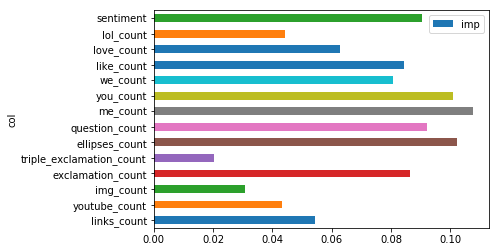

In [1672]:
# Feature Importance
feature_importance = pd.DataFrame({'imp': random_forest.feature_importances_, 'col': X.columns})
feature_importance.sort_values(['imp', 'col'])
_ = feature_importance.plot(kind='barh', x='col', y='imp')



### KNN Classification

In [1660]:

knn = KNeighborsClassifier(n_neighbors = 200)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

model = 'KNN'
accuracy = metrics.accuracy_score(y_test, y_pred)

compare_models = compare_models.append({'model': model, 'accuracy': accuracy}, ignore_index=True)
print(accuracy)


0.24389119409866297


### Cat Boost

In [1661]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

cb_model = CatBoostRegressor(iterations=10, depth=1, learning_rate=0.1)

cb_model.fit(X_train, y_train
          , cat_features = categorical_features_indices
          , eval_set=(X_test, y_test) 
          , use_best_model = True
          #, plot = True 
         )

y_pred = cb_model.predict(X_test).round().astype(int)

model = 'Cat Boost'
accuracy = metrics.accuracy_score(y_test, y_pred)

compare_models = compare_models.append({'model': model, 'accuracy': accuracy}, ignore_index=True)
print(accuracy)

0:	learn: 4.3290821	test: 4.2635031	best: 4.2635031 (0)	total: 101ms	remaining: 910ms
1:	learn: 4.1433812	test: 4.0774059	best: 4.0774059 (1)	total: 135ms	remaining: 541ms
2:	learn: 3.9865961	test: 3.9203493	best: 3.9203493 (2)	total: 148ms	remaining: 346ms
3:	learn: 3.8548432	test: 3.7883858	best: 3.7883858 (3)	total: 159ms	remaining: 238ms
4:	learn: 3.7447092	test: 3.6783553	best: 3.6783553 (4)	total: 166ms	remaining: 166ms
5:	learn: 3.6530580	test: 3.5871745	best: 3.5871745 (5)	total: 173ms	remaining: 115ms
6:	learn: 3.5771251	test: 3.5115841	best: 3.5115841 (6)	total: 181ms	remaining: 77.6ms
7:	learn: 3.5141363	test: 3.4491924	best: 3.4491924 (7)	total: 193ms	remaining: 48.3ms
8:	learn: 3.4624774	test: 3.3980206	best: 3.3980206 (8)	total: 200ms	remaining: 22.3ms
9:	learn: 3.4200344	test: 3.3561063	best: 3.3561063 (9)	total: 208ms	remaining: 0us

bestTest = 3.356106252
bestIteration = 9

0.16228676809589673


#### Compare models & visualize relative accuracy

In [1664]:
# drop a model if we need to re-run
# compare_models = compare_models[compare_models['model'] != 'Cat Boost']

In [1665]:
compare_models.sort_values(by=['accuracy'], ascending = False)

,model,accuracy
3,Logistic Regression w/ NLP,0.649608
2,Logistic Regression w/ text,0.600738
1,Logistic Regression - features only,0.257722
5,KNN,0.243891
4,Random Forest,0.234209
0,Base,0.211200
6,Cat Boost,0.162287


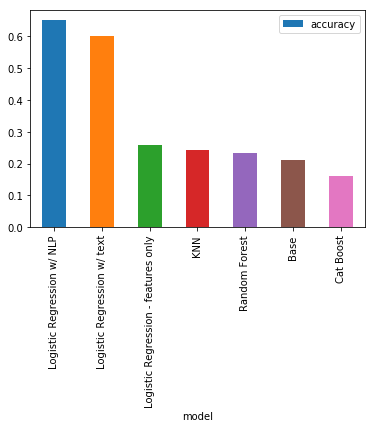

In [1666]:

compare_models.sort_values(by=['accuracy'], ascending = False).plot(kind='bar', x='model', y='accuracy')


# End